# Проект: Статистический аналих данных

**В ходе этой работы необходимо проанализоровать переданные данные о некоторых пользователях из нескольких городов, а также об их поездках. Проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
 - без подписки
      - абонентская плата отсутствует;
      - стоимость одной минуты поездки — 8 рублей;
      - стоимость старта (начала поездки) — 50 рублей;
 - с подпиской Ultra
      - абонентская плата — 199 рублей в месяц;
      - стоимость одной минуты поездки — 6 рублей;
      - стоимость старта — бесплатно.
      
      
      
План выполнения:
 - Загрузка и просмотр начальных данных
 - Предобработка данных
 - Исследовательский анализ
 - Объединение таблиц
 - Подсчетаем выручку(за весь период)
 - Проверка гипотез
 - Просмотрим некоторые распределение

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp, binom, norm, ttest_rel
import seaborn as sns

#### Шаг 1. Загрузка данных

In [ ]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_users = pd.read_csv('users_go.csv')
    data_rides = pd.read_csv('rides_go.csv')
    data_subscriptions = pd.read_csv('subscriptions_go.csv')

In [ ]:
display('Первые 5 строк: ',
        data_users.head(),
        'Общая информация:')
data_users.info()

'Первые 5 строк: '

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
display('Первые 5 строк: ',
        data_rides.head(),
        'Общая информация:')
data_rides.info()

'Первые 5 строк: '

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [ ]:
#subscriptions
display('Первые 5 строк: ',
        data_subscriptions.head(),
        'Общая информация:')
data_subscriptions.info()

'Первые 5 строк: '

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div class='alert alert-info'>
    По результатам загрузки данных  и выводе общей информации можно сказать, что пропущенных значений нету, но это будет далее исследовано подробнее. Есть не корректные типы столбцов. Достаточно сильно различаются размеры датафреймов.
</div>

#### Шаг 2. Предобработка данных

##### Изменение типов столбцов

**Во всех трех ДатаФреймах столбцы соответствуют своему типу, кроме столбца с датой в data_rides. Изменим тип этого столбца на соответствующий дате**

In [ ]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')

**Проверка на корректность изменения.**

In [ ]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создание нового столбца с номером месяца

In [ ]:
data_rides['month'] = pd.DatetimeIndex(data_rides['date']).month

In [ ]:
print(pd.DatetimeIndex(data_rides['date']).month.unique().sort_values())
pd.DatetimeIndex(data_rides['date']).year.unique()

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='date')


Int64Index([2021], dtype='int64', name='date')

<div class='alert alert-info'>
    По результатам вывода информации о всех возможных месяцах и годах делаем вывод, что данные собраны за весь 2021 год по всем месяцам.
</div>

**Проверка на корректность появления нового столбца.**

In [ ]:
data_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Проверка на пропущенные значения и дубликаты

**1) data_users**

In [ ]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [ ]:
print(data_users[data_users.duplicated()])
data_users.duplicated().sum()

      user_id        name  age            city subscription_type
1534      293       Агата   26       Краснодар             ultra
1535       16      Амалия   27       Краснодар             ultra
1536      909  Константин   20    Екатеринбург              free
1537      403      Полина   19            Сочи             ultra
1538      908      Рустам   30          Тюмень              free
1539       43    Стефания   22            Омск             ultra
1540      127       Павел   25       Пятигорск             ultra
1541      659       Злата   27  Ростов-на-Дону             ultra
1542      204      Руслан   30       Пятигорск             ultra
1543      153      Герман   23          Москва             ultra
1544     1245      Регина   27       Пятигорск              free
1545      807   Александр   28    Екатеринбург              free
1546      924       Мария   23       Пятигорск              free
1547      635      Герман   21          Москва             ultra
1548      136     Марсель

31

**Видим 31 дубликат не очень много, поэтому можно удалить**

In [ ]:
start_user_shape = data_users.shape[0]

In [ ]:
data_users = data_users.drop_duplicates()

In [ ]:
finish_user_shape = data_users.shape[0]

In [ ]:
((start_user_shape - finish_user_shape) / start_user_shape) * 100

1.9808306709265175

**По итогу обработки удалено почти 2 % строк из-за наличия дубликатов, что является допустимым. Пропущенных значений не обнаружено.**

**2) data_rides**

In [ ]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [ ]:
data_users.duplicated().sum()

0

**Пропущенных значений нету и дубликатов тоже.**

**3)data_subscriptions**

In [ ]:
data_subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [ ]:
data_subscriptions.duplicated().sum()

0

**Пропущенных значений и дубликатов нету**

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

,city,counts
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


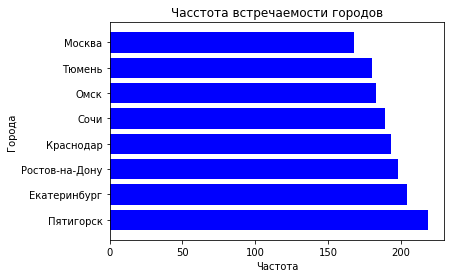

In [ ]:
pivot_users = data_users['city'].value_counts().reset_index()
pivot_users = pivot_users.rename(columns = {'index':'city',
                                            'city': 'counts'})
plt.barh(pivot_users['city'], pivot_users['counts'], color='b')
plt.title('Часстота встречаемости городов')
plt.xlabel('Частота')
plt.ylabel('Города')
pivot_users

In [ ]:
(round(((pivot_users.loc[0, 'counts'] - pivot_users.loc[pivot_users.shape[0] - 1, 'counts']) /
       pivot_users.loc[0, 'counts']) * 100, 1))

23.3

<div class='alert alert-info'>
Из постоенной диаграммы можно сделать вывод, что больше всего пользователей находятся в пятигорске, а меньше всего в Москве. Отличие между количеством пользователей в этих городах составляет 23.3 % достаточно существенно
</div>

##### Cоотношение пользователей с подпиской и без подписки

,subscription,counts
0,free,835
1,ultra,699


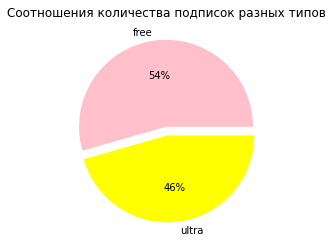

In [ ]:
pivot_subscription = data_users['subscription_type'].value_counts().reset_index()
pivot_subscription = pivot_subscription.rename(columns = {'index':'subscription',
                                            'subscription_type': 'counts'})
plt.pie(pivot_subscription['counts'], labels = pivot_subscription['subscription'],
  autopct='%1.0f%%', explode = (0.05, 0.05), colors = ['pink', 'yellow'])
plt.title('Соотношения количества подписок разных типов')
pivot_subscription

**Приложение без подписки используют чаще, чем с подпиской.**

#####  Возраст пользователей

,age,counts
28,43,1
27,39,1
26,37,2
25,38,3
24,12,4
23,36,6
22,13,8
21,14,9
20,15,13
19,35,15


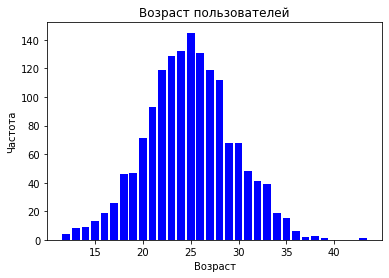

In [ ]:
pivot_age = data_users['age'].value_counts().reset_index()
pivot_age = pivot_age.rename(columns = {'index':'age',
                                            'age': 'counts'}).sort_values(by = 'counts')
plt.bar(pivot_age['age'], pivot_age['counts'], color='b')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
pivot_age

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

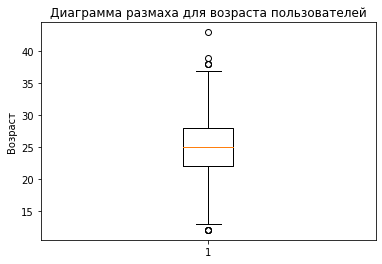

In [ ]:
plt.boxplot(data_users['age'])
plt.title('Диаграмма размаха для возраста пользователей')
plt.ylabel('Возраст')
data_users['age'].describe()

<div class='alert alert-info'>
Из диаграммы размаха можно cделать вывод, что в этой статистике есть несколько выбивающихся значений, а основуную часть данных состаляют люди от 22 до 28 лет.
</div>

##### Расстояние, которое пользователь преодолел за одну поездку

Text(0, 0.5, 'Количество пользователей')

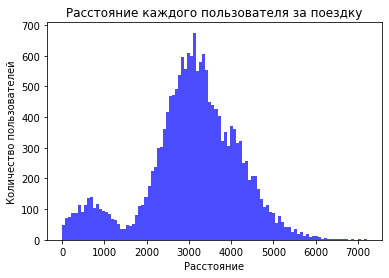

In [ ]:
plt.hist(data_rides['distance'], bins=100, alpha=0.7, color='b')
plt.title('Расстояние каждого пользователя за поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

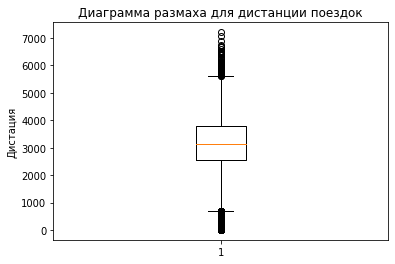

In [ ]:
plt.boxplot(data_rides['distance'])
plt.title('Диаграмма размаха для дистанции поездок')
plt.ylabel('Дистация')
data_rides['distance'].describe()

In [ ]:
1 - (data_rides.shape[0] - data_rides.query('(distance > 6800) | (distance < 1000) ').shape[0]) / data_rides.shape[0]

0.07610139473101618

<div class='alert alert-info'>
Из полученного диаграммы размаха можно сказать, что в основном  пользователи ездят на расстояния от 2500 до 3700 метров. Выбросов оказалось около 1400, что составляет почти 7.6 % всего датафрейма, удалять не следует.
</div>

##### Продолжительность поездок

Text(0, 0.5, 'Количество пользователей')

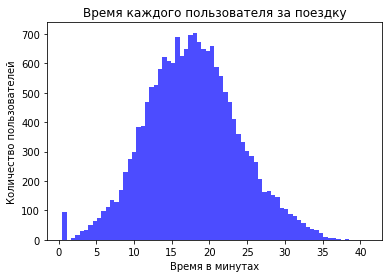

In [ ]:
plt.hist(data_rides['duration'], bins=70, alpha=0.7, color='b')
plt.title('Время каждого пользователя за поездку')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

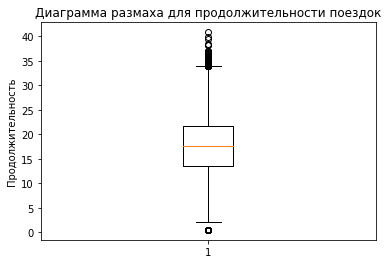

In [ ]:
plt.boxplot(data_rides['duration'])
plt.title('Диаграмма размаха для продолжительности поездок')
plt.ylabel('Продолжительность')
data_rides['duration'].describe()

In [ ]:
1 - (data_rides.shape[0] - data_rides.query('(duration > 34) | (duration < 1.5)').shape[0]) / data_rides.shape[0]

0.009408899712198382

<div class='alert alert-info'>
    Получаем, что в основном поездка затрачивает от 13 до 22 минут. Выбросы составляют около 1 % .
</div>

#### Шаг 4. Объединение данных

In [ ]:
# Объединение данных о пользователях, поездках и подписках
data_all = pd.merge(data_users, data_rides, on='user_id', how='inner')
data_all = pd.merge(data_all, data_subscriptions, on = 'subscription_type', how='inner')
data_all.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [ ]:
data_ultra = data_all[data_all['subscription_type'] == 'ultra']
data_free = data_all[data_all['subscription_type'] == 'free']

In [ ]:
print('Размерность первого датафрейма: ', data_ultra.shape,'Размерность второго датафрейма: ', data_free.shape)

Размерность первого датафрейма:  (6500, 12) Размерность второго датафрейма:  (11568, 12)


In [ ]:
print(data_ultra.shape[0] + data_free.shape[0])
print(data_rides.shape[0])
print(data_ultra['subscription_type'].unique())
print(data_free['subscription_type'].unique())

18068
18068
['ultra']
['free']


In [ ]:
display(data_all.isna().sum(),
data_ultra.isna().sum(),
data_free.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

<div class='alert alert-info'>
Cумма размерностей датафреймов равна размерности самого большого из загруженных, значит распределения произошли корректно. Также новые датафреймы были изучены на наличие пропусков, их не обнаружено
</div>

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, round(y[i] // 2, 2), round(y[i],2), ha = 'center')

,subscription_type,distance
0,free,3045.495282
1,ultra,3115.445388


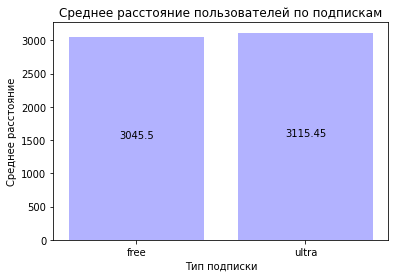

In [ ]:
data_distance_pivot = (data_all.pivot_table(index = 'subscription_type', values = 'distance', aggfunc = 'mean').
                  reset_index())
plt.bar(data_distance_pivot['subscription_type'], data_distance_pivot['distance'], color = 'b', alpha = 0.3)
plt.title('Среднее расстояние пользователей по подпискам')
plt.ylabel('Среднее расстояние')
plt.xlabel('Тип подписки')
addlabels(data_distance_pivot['subscription_type'], data_distance_pivot['distance'])
data_distance_pivot

**Пользователи с подпиской проезжают большее расстояние, чем без подписки.**

,subscription_type,duration
0,free,17.390909
1,ultra,18.541985


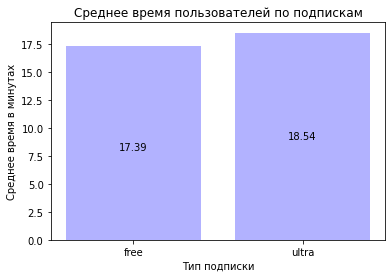

In [ ]:
data_time_pivot = (data_all.pivot_table(index = 'subscription_type', values = 'duration', aggfunc = 'mean').
                  reset_index())
plt.bar(data_time_pivot['subscription_type'], data_time_pivot['duration'], color = 'b', alpha = 0.3)
plt.title('Среднее время пользователей по подпискам')
plt.ylabel('Среднее время в минутах')
plt.xlabel('Тип подписки')
addlabels(data_time_pivot['subscription_type'], data_time_pivot['duration'])
data_time_pivot

**Пользователи с подпиской также тратят больше времени на поездки, чем без подписки.**

In [ ]:
display('Статистика пользователей с подпиской', round(data_ultra[['distance', 'duration']].describe(), 2),
        'Cтатистика пользователей без подписки', round(data_free[['distance', 'duration']].describe(), 2))

'Статистика пользователей с подпиской'

,distance,duration
count,6500.00,6500.00
mean,3115.45,18.54
std,836.90,5.57
min,244.21,3.76
25%,2785.44,14.52
50%,3148.64,18.18
75%,3560.57,21.88
max,5699.77,40.82


'Cтатистика пользователей без подписки'

,distance,duration
count,11568.00,11568.00
mean,3045.50,17.39
std,1246.17,6.33
min,0.86,0.50
25%,2366.56,12.96
50%,3114.65,17.33
75%,3905.70,21.59
max,7211.01,34.95


<div class='alert alert-info'>
Из выведенной статистики можно сказать, что у пользователей с подпиской в основном дорога составляет от 2785 до 3560 метров, что занимает от 14 до 21 минуты. В свою очередь в людей без подписки интервал дистанции шире от 2366 до 3900 и на это они тратят в основном от 13 до 22 минут.
</div>

#### Шаг 5. Подсчёт выручки

In [ ]:
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [ ]:
data_ultra_price = data_ultra
data_ultra_price.loc[:, ['distance', 'duration']] =np.ceil(data_ultra_price.loc[:, ['distance', 'duration']])
data_aggregated_ultra  = data_ultra_price.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'city': 'count',
    'duration': 'sum'
}).reset_index().rename(columns = {'city':'trips'})
data_aggregated_ultra['duration'] = np.ceil(data_aggregated_ultra['duration'])
data_aggregated_ultra

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,user_id,month,distance,trips,duration
0,1,1,7028.0,2,42.0
1,1,4,755.0,1,7.0
2,1,8,6724.0,2,46.0
3,1,10,5811.0,2,32.0
4,1,11,7005.0,3,56.0
...,...,...,...,...,...
4528,699,6,4073.0,1,17.0
4529,699,8,7020.0,2,45.0
4530,699,9,6366.0,2,31.0
4531,699,10,4708.0,1,16.0


In [ ]:
data_aggregated_ultra.isna().sum()

user_id     0
month       0
distance    0
trips       0
duration    0
dtype: int64

In [ ]:
data_free_price = data_free
data_free_price.loc[:, ['distance', 'duration']] =np.ceil(data_free_price.loc[:, ['distance', 'duration']])
data_aggregated_free  = data_free.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'city': 'count',
    'duration': 'sum'
}).reset_index().rename(columns = {'city':'trips'})
data_aggregated_free['duration'] = np.ceil(data_aggregated_free['duration'])
data_aggregated_free

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,user_id,month,distance,trips,duration
0,700,1,2516.0,1,15.0
1,700,2,13449.0,5,89.0
2,700,3,3799.0,1,19.0
3,700,4,2985.0,1,16.0
4,700,6,5929.0,2,29.0
...,...,...,...,...,...
6793,1534,6,3411.0,2,26.0
6794,1534,8,7623.0,2,48.0
6795,1534,9,4929.0,1,23.0
6796,1534,11,13353.0,4,78.0


In [ ]:
data_aggregated_free.isna().sum()

user_id     0
month       0
distance    0
trips       0
duration    0
dtype: int64

In [ ]:
data_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
data_aggregated_ultra['price'] = np.ceil(data_subscriptions.loc[1, 'subscription_fee'] +
                                  data_subscriptions.loc[1, 'minute_price'] * data_aggregated_ultra['duration'])
data_aggregated_ultra

,user_id,month,distance,trips,duration,price
0,1,1,7028.0,2,42.0,451.0
1,1,4,755.0,1,7.0,241.0
2,1,8,6724.0,2,46.0,475.0
3,1,10,5811.0,2,32.0,391.0
4,1,11,7005.0,3,56.0,535.0
...,...,...,...,...,...,...
4528,699,6,4073.0,1,17.0,301.0
4529,699,8,7020.0,2,45.0,469.0
4530,699,9,6366.0,2,31.0,385.0
4531,699,10,4708.0,1,16.0,295.0


In [ ]:
data_aggregated_free['price'] = np.ceil(data_subscriptions.loc[0, 'start_ride_price'] * data_aggregated_free['trips'] +
                                  data_subscriptions.loc[0, 'minute_price'] * data_aggregated_free['duration'])
data_aggregated_free

,user_id,month,distance,trips,duration,price
0,700,1,2516.0,1,15.0,170.0
1,700,2,13449.0,5,89.0,962.0
2,700,3,3799.0,1,19.0,202.0
3,700,4,2985.0,1,16.0,178.0
4,700,6,5929.0,2,29.0,332.0
...,...,...,...,...,...,...
6793,1534,6,3411.0,2,26.0,308.0
6794,1534,8,7623.0,2,48.0,484.0
6795,1534,9,4929.0,1,23.0,234.0
6796,1534,11,13353.0,4,78.0,824.0


In [ ]:
# check
data_aggregated_free['price'].sum() + data_aggregated_ultra['price'].sum()

3878641.0

In [ ]:
print('Годовая выручка пользователей с подпиской: ', data_aggregated_ultra['price'].sum())
print('Выпучка компании за месяц в среднем за пользователя с подпиской ',
      round(np.mean(data_aggregated_ultra.groupby('month')['price'].mean())))

Годовая выручка пользователей с подпиской:  1644537.0
Выпучка компании за месяц в среднем за пользователя с подпиской  363


In [ ]:
print('Годовая выручка пользователей без подписки: ', data_aggregated_free['price'].sum())
print('Выпучка компании за месяц в среднем за пользователя без подписки',
      round(np.mean(data_aggregated_free.groupby('month')['price'].mean())))

Годовая выручка пользователей без подписки:  2234104.0
Выпучка компании за месяц в среднем за пользователя без подписки 329


In [ ]:
data_aggregated_free['price'].sum()

2234104.0

#### Шаг 6. Проверка гипотез

##### Выгоднее ли пользователи с подпиской или нет

<div class='alert alert-info'>
Задаем гипотезу:


H0: Средняя продолжительность поездок пользователей с подпиской не больше средней продолжительности поездок пользователей без подписки.


H1: Средняя продолжительность поездок пользователей с подпиской больше средней продолжительности поездок пользователей без подписки.
</div>

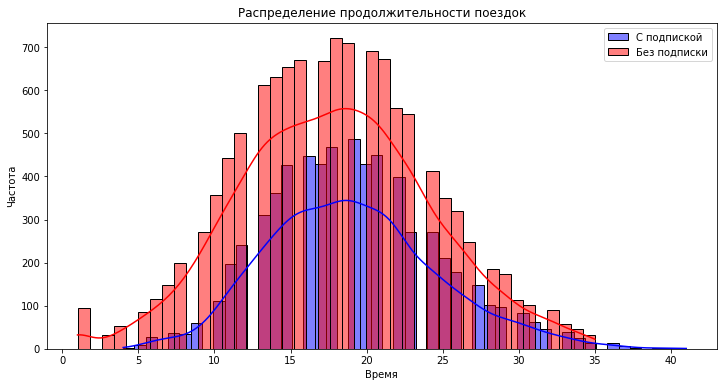

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data_ultra['duration'], kde=True, color='blue', label='С подпиской')
sns.histplot(data_free['duration'], kde=True, color='red', label='Без подписки')
plt.legend()
plt.title('Распределение продолжительности поездок')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

In [ ]:
# Проведение t-теста
t_stat, p_val = ttest_ind(data_ultra['duration'], data_free['duration'])
print('t-test statistic:', t_stat)
print('p-value:', p_val)

t-test statistic: 12.186464491247767
p-value: 4.991890744147325e-34


<div class='alert alert-info'>
При p-значении
2.5608196633291235e−34
  мы можем отклонить нулевую гипотезу. Это свидетельствует о том, что полученные результаты являются статистически значимыми и нулевую гипотезу отвергаем.
</div>

In [ ]:
if p_val < 0.05:
    print("Пользователи с подпиской тратят значительно больше cреднего времени на поездки.")
else:
    print("Нет значимых различий в среднем времени поездок между пользователями с подпиской и без.")

Пользователи с подпиской тратят значительно больше cреднего времени на поездки.


**Данный результат можно было ещё увидеть в пункте 4, на диграмме соотношения среднего времени. Отсюда можно сказать, что действительно пользователи с подпиской являются выгоднее для компании**

##### Гипотеза про расстояние пользователей с подпиской

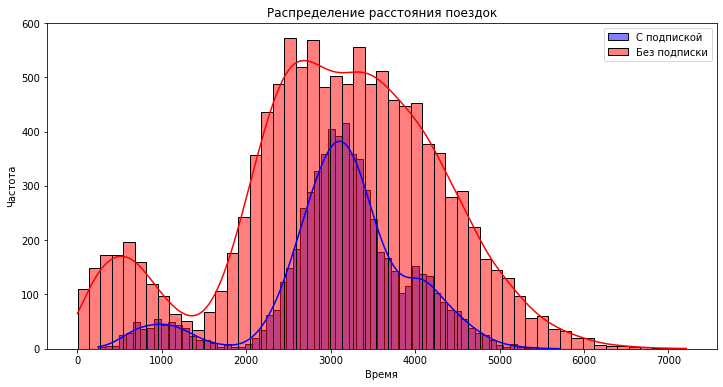

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data_ultra['distance'], kde=True, color='blue', label='C подпиской')
sns.histplot(data_free['distance'], kde=True, color='red', label='Без подписки')
plt.legend()
plt.title('Распределение расстояния поездок')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.show()

<div class='alert alert-info'>
Задаем гипотезу:


H0: Среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 метров


H1: Среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров
</div>

In [ ]:
# Поскольку мы проводим односторонний тест, делим p-value на 2 и проверяем, если t_stat отрицательный
print('t-test statistic:', t_stat)
print('p-value (one-tailed):', p_val)

t-test statistic: -1.353586112987382
p-value (one-tailed): 0.9120422337080507


In [ ]:
# Интерпретация результата
alpha = 0.05
if p_val < alpha:
    print('''Отвергаем нулевую гипотезу, среднее расстояние,
          которое проезжают пользователи с подпиской, больше 3130 метров.''')
else:
    print('''Нет оснований отвергать нулевую гипотезу, возможно среднее расстояние,
    которое проезжают подписчики равно 3130 метров''')

Нет оснований отвергать нулевую гипотезу, возможно среднее расстояние,
    которое проезжают подписчики равно 3130 метров


<div class='alert alert-info'>
По результатам проведенного статистического анализа нет оснований отвергать нулевую гипотезу. Это означает, что на основании имеющихся данных мы не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров. Следовательно, можно предположить, что среднее расстояние действительно равно 3130 метрам, или по крайней мере не отличается от него в статистически значимой степени.
</div>

##### Проверка гипотезы о цене

<div class='alert alert-info'>
Задаем гипотезы:

H0: Средняя помесячная выручка от пользователей с подпиской не больше средней помесячной выручки от пользователей без подписки.


H1: Средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручки от пользователей без подписки.
</div>

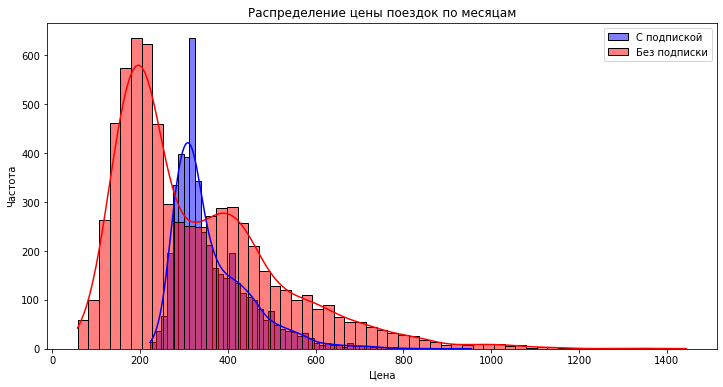

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data_aggregated_ultra['price'], kde=True, color='blue', label='C подпиской')
sns.histplot(data_aggregated_free['price'], kde=True, color='red', label='Без подписки')
plt.legend()
plt.title('Распределение цены поездок по месяцам')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

In [ ]:
# Проведение t-теста для независимых выборок
t_stat, p_val = ttest_ind(data_aggregated_ultra['price'], data_aggregated_free['price'], alternative='greater')
print('t-test statistic:', t_stat)
print('p-value:', p_val)
# Интерпретация результата
alpha = 0.05
if p_val < alpha:
    print("Помесячная выручка от пользователей с подпиской значительно выше, чем выручка от пользователей без подписки.")
else:
    print("Нет значимых различий в помесячной выручке между пользователями с подпиской и без.")

t-test statistic: 11.64246602360774
p-value: 1.8850394384715216e-31
Помесячная выручка от пользователей с подпиской значительно выше, чем выручка от пользователей без подписки.


**Помесячная выручка от пользователей с подпиской значительно выше, чем выручка от пользователей без подписки. Это не отвергается статистически значимыми результатами t-теста, который показал, что средняя выручка от подписчиков существенно превышает среднюю выручку от пользователей без подписки. Данный результат свидетельствует о том, что пользователи с подпиской приносят компании больше дохода на регулярной основе по сравнению с пользователями без подписки.**

##### Гипотеза про техническую поддержку

**Для проверки гипотезы о том, что количество обращений в техподдержку снизилось после обновления серверов, потребуется использовать парный t-тест. Парный t-тест сравнивает средние значения двух зависимых выборок (в данном случае, количества обращений до и после обновления серверов для одних и тех же пользователей).**

<div class='alert alert-info'>
Задаем гипотезы:


H0: Количество обращений в техническую поддержку не изменилось или незначительно изменилось после обновления серверов.


H1:Количество обращений в техническую поддержку значительно снизилось после обновления серверов.
</div>

In [ ]:
calls_before = np.array([10, 15, 7, 8, 12, 14, 9, 11, 13, 10,
                         16, 19, 20, 18, 21, 17, 23, 22, 25, 24,
                         26, 28, 27, 29, 30, 35, 33, 31, 32, 34])
calls_after = np.array([6, 10, 5, 7, 10, 12, 8, 9, 11, 8,
                        15, 18, 19, 17, 20, 16, 21, 19, 23, 22,
                        14, 18, 5, 27, 20, 3, 30, 8, 10, 11])

# Проводим t-тест для гипотезы "количество обращений не изменилось"
t_statistic_1, p_value_1 = ttest_rel(calls_before, calls_after)

# Проводим t-тест для гипотезы "количество обращений снизилось"
t_statistic_2, p_value_2 = ttest_rel(calls_before, calls_after, alternative='less')

print('Статистика t-теста:', t_stat)
print('Одностороннее p-значение:', p_val)

# Интерпретация результата
alpha = 0.05
if p_value_1 > alpha:
    print("Гипотеза о равенстве количества обращений не отвергается")
else:
    print("Гипотеза о равенстве количества обращений отвергается")

if p_value_2 > alpha:
    print("Гипотеза о снижении количества обращений не отвергается")
else:
    print("Гипотеза о снижении количества обращений отвергается")


Статистика t-теста: 11.64246602360774
Одностороннее p-значение: 1.8850394384715216e-31
Гипотеза о равенстве количества обращений отвергается
Гипотеза о снижении количества обращений не отвергается


In [ ]:
# check
calls_before.mean().round(1), calls_after.mean().round(1)

(20.6, 14.1)

#### Шаг 7. Распределения

##### Промокоды

In [ ]:
# Заданные параметры
p = 0.1
k = 100
probability_threshold = 0.05

In [ ]:
# Функция для нахождения минимального N
def find_min_n(k, p, probability_threshold):
    N = k
    while True:
        cdf_value = binom.cdf(k - 1, N, p)
        if cdf_value <= probability_threshold:
            return N
        N += 1

# Найти минимальное N
min_N = find_min_n(k, p, probability_threshold)
print(f"Минимальное количество промокодов, которые нужно разослать: {min_N}")


Минимальное количество промокодов, которые нужно разослать: 1161


In [ ]:
# Построение графика распределения
n_values = np.arange(min_N - 50, min_N + 50)
probabilities = binom.cdf(k - 1, n_values, p)


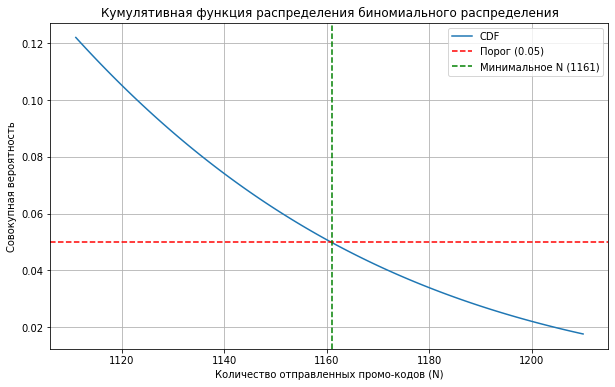

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(n_values, probabilities, label='CDF')
plt.axhline(y=probability_threshold, color='r', linestyle='--', label='Порог (0.05)')
plt.axvline(x=min_N, color='g', linestyle='--', label=f'Минимальное N ({min_N})')
plt.xlabel('Количество отправленных промо-кодов (N)')
plt.ylabel('Совокупная вероятность')
plt.title('Кумулятивная функция распределения биномиального распределения')
plt.legend()
plt.grid()
plt.show()

**Минимальное количество промокодов, которые нужно разослать, чтобы вероятность не выполнения плана была примерно 5%, составляет 1161. На графике видно распределение вероятностей числа пользователей, продливших подписку, с выделением планового значения и уровня порога вероятности.**

##### Push-уведомления

In [ ]:
# Параметры биномиального распределения
n = 1_000_000
p = 0.4

In [ ]:
# Параметры нормального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
# Значение, для которого нужно найти вероятность
x = 399_500
# Вычисление вероятности с использованием нормальной аппроксимации
probability = norm.cdf(x, mu, sigma)

In [ ]:
print(f"Среднее (mu): {mu}")
print(f"Стандартное отклонение (sigma): {sigma}")
print(f"Вероятность того, что уведомление откроют не более {x} пользователей: {round(probability * 100, 2)}")


Среднее (mu): 400000.0
Стандартное отклонение (sigma): 489.89794855663564
Вероятность того, что уведомление откроют не более 399500 пользователей: 15.37


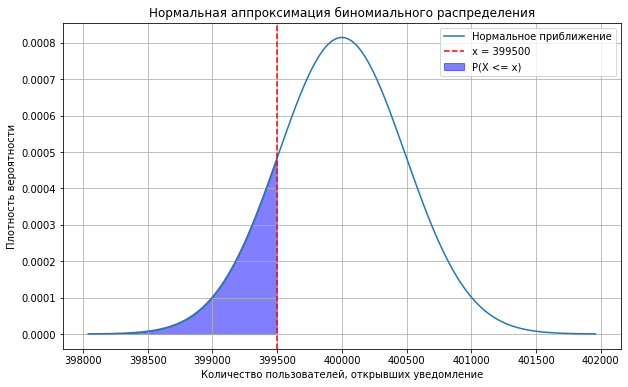

In [ ]:
# Построение графика
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y_values = norm.pdf(x_values, mu, sigma)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Нормальное приближение')
plt.axvline(x, color='r', linestyle='--', label=f'x = {x}')
plt.fill_between(x_values, y_values, where=(x_values <= x), color='b', alpha=0.5, label='P(X <= x)')
plt.xlabel('Количество пользователей, открывших уведомление')
plt.ylabel('Плотность вероятности')
plt.title('Нормальная аппроксимация биномиального распределения')
plt.legend()
plt.grid(True)
plt.show()

**На основании нормальной аппроксимации биномиального распределения, вероятность того, что уведомление откроют не более 399.500 пользователей, можно оценить как P( X <= 399.500 ) = 15.37 %**

<div class='alert alert-info'>
На основании биномиального распределения вероятность того, что уведомление откроют не более 359,900 пользователей из 1,000,000, составляет 15%. Это указывает на то, что в 15% случаев количество открытий уведомлений будет значительно ниже ожидаемого уровня в 40%. В зависимости от целей кампании и средних показателей открытия уведомлений, такая вероятность может быть неприемлемой и сигнализировать о необходимости улучшения стратегии рассылки. Если текущее положение дел не удовлетворяет бизнес-целям, необходимо рассмотреть возможные меры по увеличению вовлеченности пользователей.
</div>

#### Шаг 8. Общий вывод

1)   В ходе проекта был проведен анализ данных компании по прокату самокатов. Для начала были загружены датафреймы с инфомацией о пользователях, поездками и расценками. Изучена основная информация и выведены первые строки.


2)  Далее проведена предобработка данных во всех трех таблицах, пропущенных значений не обнаружено, удалены некоторые дубликаты, в итоге потеряно было около 2 % строк. Изменён тип столбца с датой и также добавлен новый столбец с номером месяца поездки для каждого пользователя.
  
  
3)  После представлены распределения некоторых параметров. А именно частота встречаемости городов, в Пятигорске используют самокаты чаще всего, а в Москве реже. Соотношение между пользователями с подпиской и без подписки. Без подписки пользователей больше, чем с подпиской. Диаграмма возраста показала, что больше всего людей с возрастом в 25 лет, меньше всего пользователей с возрастом меньше 15 и больше 35 лет. По расстояниям, которые пользователь преодолел можно сказать, что в основном дистация составляет от 2700 до 3400 метров. По диаграмме продолжительности поездок делаем вывод, что чаще всего поездка составляет от 17-20 минут.
  
  
4)  Произведено объединение всех трех таблиц, а после она была разбита на две, пользователи с подпиской и без.
  
5)  Созданы ещё два датафрейма с агрегированными данными о поездках. Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. А также вычислена помесечная выручка компании за месяц с каждого пользователя. Также выявлено, что с подписчиков за год компания заработала 1644537 рублей, в месяц это около 363 рубля с подписчика, а с пользователей без подписки выручка составила 2234104 рублей, с ценой в 329 рублей в месяц с пользователя.
  
6) При проверке гипотез были сделаны следующие выводы:
- пользователи с подпиской являются выгоднее для компании;
- Нельзя утверждать, что износ самокатов будет происходить быстро, так как скорее всего среднее расстояние не больше 3130 метров;
- помесячная выручка от пользователей с подпиской значительно выше, чем выручка от пользователей без подписки.
- для проверки гипотезы о том, что количество обращений в техподдержку снизилось после обновления серверов, потребуется использовать парный t-тест, который показал, что количество обращений в техподдержку значительно снизилось после обновления серверов.

7) Сначала была построена нормальная аппроксимация биномиального распределения, основываясь на известной вероятности открытия уведомления (примерно 40%) и количестве уведомлений, которые планируется разослать (1 миллион). Это позволило быстро оценить вероятность открытия уведомления до определенного количества пользователей.Далее был построен график распределения вероятностей, показывающий, как вероятность того, что уведомление будет открыто, изменяется в зависимости от количества пользователей, которые его открыли. На графике была выделена область, соответствующая заданной вероятности открытия уведомления не более 399,500 пользователей. Таким образом, на основе проведенного анализа, мы можем с уверенностью сказать, что вероятность того, что уведомление откроют не более указанного числа пользователей, составляет примерно 15%. Это позволяет отделу маркетинга GoFast более точно спланировать и оценить эффективность своей кампании по разсылке уведомлений. Также выявлено, что надо разослать 1161 промокодов, чтобы вероятность не выполнить план была примерно 5%.


 Сотрудникам кампании следует опираться на выводы и числовые характеристики представленные в проекте, чтобы улучшать свой сервис и прибыль. Если текущее положение дел не удовлетворяет бизнес-целям, необходимо рассмотреть возможные меры по увеличению вовлеченности пользователей.